# Running the file<br>
If you wish to use your own copy of the data, use the following command:<br>
<br>
``python housing-price-main.py [{-i |--input=}<train-csv>] [-h | --help]``<br>
<br>
Here are some examples:<br>
<br>
``python housing-price-main.py --input=train.csv``<br>
``python housing-price-main.py -i train.csv``<br>
``python housing-price-main.py``<br>
``python housing-price-main.py --help``<br>
<br>
All of these arguments are optional. Providing no arguments makes the code read from the default location, i.e. ```./data```.<br>
<br>
# Instructions on regenerating this Jupyter Notebook<br>
The Jupyter notebook can be regenerated by installing P2J, like so:<br>
<br>
``pip install p2j``<br>
<br>
and running the following:<br>
<br>
``p2j -o code/housing-price-main.py -t notebook/housing-price-main.ipynb``

# Library Imports

In [1]:
import getopt
import logging
import sys
import warnings

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
# # Constants
# A bunch of constants are set up so that strings don't clutter the source everywhere.
from sklearn.preprocessing import MinMaxScaler

# Constants<br>
 Setting up Constants so that strings are not scattered everywhere

In [3]:
DEFAULT_DATASET_LOCATION = "../data"
DEFAULT_HOUSING_PRICE_CSV_FILENAME = "train.csv"
VALUE_FIELD = "value"
VALUES_FIELD = "values"

In [4]:
REGULARIZATION_COEFFICIENT = "REGULARIZATION_COEFFICIENT"
REGULARIZED_MODEL = "REGULARIZED_MODEL"
R2_SCORE = "R2_SCORE"
ROOT_MEAN_SQUARE_ERROR = "ROOT_MEAN_SQUARE_ERROR"

# Metadata<br>
This data structure is set up by parsing the data_description.txt, so as to automatically get information<br>
that can be used to validate data, automatically transform data into dummy and/or ordinal variables, without<br>
writing them all out manually.

In [5]:
METADATA = [{'name': 'MSSubClass', 'meaning': 'Identifies the type of dwelling involved in the sale.',
             'values': [{'value': '20', 'meaning': '1-STORY 1946 & NEWER ALL STYLES'},
                        {'value': '30', 'meaning': '1-STORY 1945 & OLDER'},
                        {'value': '40', 'meaning': '1-STORY W/FINISHED ATTIC ALL AGES'},
                        {'value': '45', 'meaning': '1-1/2 STORY - UNFINISHED ALL AGES'},
                        {'value': '50', 'meaning': '1-1/2 STORY FINISHED ALL AGES'},
                        {'value': '60', 'meaning': '2-STORY 1946 & NEWER'},
                        {'value': '70', 'meaning': '2-STORY 1945 & OLDER'},
                        {'value': '75', 'meaning': '2-1/2 STORY ALL AGES'},
                        {'value': '80', 'meaning': 'SPLIT OR MULTI-LEVEL'}, {'value': '85', 'meaning': 'SPLIT FOYER'},
                        {'value': '90', 'meaning': 'DUPLEX - ALL STYLES AND AGES'},
                        {'value': '120', 'meaning': '1-STORY PUD (Planned Unit Development) - 1946 & NEWER'},
                        {'value': '150', 'meaning': '1-1/2 STORY PUD - ALL AGES'},
                        {'value': '160', 'meaning': '2-STORY PUD - 1946 & NEWER'},
                        {'value': '180', 'meaning': 'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'},
                        {'value': '190', 'meaning': '2 FAMILY CONVERSION - ALL STYLES AND AGES'}]},
            {'name': 'MSZoning', 'meaning': 'Identifies the general zoning classification of the sale.',
             'values': [{'value': 'A', 'meaning': 'Agriculture'}, {'value': 'C', 'meaning': 'Commercial'},
                        {'value': 'FV', 'meaning': 'Floating Village Residential'},
                        {'value': 'I', 'meaning': 'Industrial'}, {'value': 'RH', 'meaning': 'Residential High Density'},
                        {'value': 'RL', 'meaning': 'Residential Low Density'},
                        {'value': 'RP', 'meaning': 'Residential Low Density Park'},
                        {'value': 'RM', 'meaning': 'Residential Medium Density'}]},
            {'name': 'LotFrontage', 'meaning': 'Linear feet of street connected to property', 'values': []},
            {'name': 'LotArea', 'meaning': 'Lot size in square feet', 'values': []},
            {'name': 'Street', 'meaning': 'Type of road access to property',
             'values': [{'value': 'Grvl', 'meaning': 'Gravel'}, {'value': 'Pave', 'meaning': 'Paved'}]},
            {'name': 'Alley', 'meaning': 'Type of alley access to property',
             'values': [{'value': 'Grvl', 'meaning': 'Gravel'}, {'value': 'Pave', 'meaning': 'Paved'},
                        {'value': 'NA', 'meaning': 'No alley access'}]},
            {'name': 'LotShape', 'meaning': 'General shape of property',
             'values': [{'value': 'Reg', 'meaning': 'Regular'}, {'value': 'IR1', 'meaning': 'Slightly irregular'},
                        {'value': 'IR2', 'meaning': 'Moderately Irregular'}, {'value': 'IR3', 'meaning': 'Irregular'}]},
            {'name': 'LandContour', 'meaning': 'Flatness of the property',
             'values': [{'value': 'Lvl', 'meaning': 'Near Flat/Level'}, {'value': 'Bnk',
                                                                         'meaning': 'Banked - Quick and significant rise from street grade to building'},
                        {'value': 'HLS', 'meaning': 'Hillside - Significant slope from side to side'},
                        {'value': 'Low', 'meaning': 'Depression'}]},
            {'name': 'Utilities', 'meaning': 'Type of utilities available',
             'values': [{'value': 'AllPub', 'meaning': 'All public Utilities (E,G,W,& S)'},
                        {'value': 'NoSewr', 'meaning': 'Electricity, Gas, and Water (Septic Tank)'},
                        {'value': 'NoSeWa', 'meaning': 'Electricity and Gas Only'},
                        {'value': 'ELO', 'meaning': 'Electricity only'}]},
            {'name': 'LotConfig', 'meaning': 'Lot configuration',
             'values': [{'value': 'Inside', 'meaning': 'Inside lot'}, {'value': 'Corner', 'meaning': 'Corner lot'},
                        {'value': 'CulDSac', 'meaning': 'Cul-de-sac'},
                        {'value': 'FR2', 'meaning': 'Frontage on 2 sides of property'},
                        {'value': 'FR3', 'meaning': 'Frontage on 3 sides of property'}]},
            {'name': 'LandSlope', 'meaning': 'Slope of property',
             'values': [{'value': 'Gtl', 'meaning': 'Gentle slope'}, {'value': 'Mod', 'meaning': 'Moderate Slope'},
                        {'value': 'Sev', 'meaning': 'Severe Slope'}]},
            {'name': 'Neighborhood', 'meaning': 'Physical locations within Ames city limits',
             'values': [{'value': 'Blmngtn', 'meaning': 'Bloomington Heights'},
                        {'value': 'Blueste', 'meaning': 'Bluestem'}, {'value': 'BrDale', 'meaning': 'Briardale'},
                        {'value': 'BrkSide', 'meaning': 'Brookside'}, {'value': 'ClearCr', 'meaning': 'Clear Creek'},
                        {'value': 'CollgCr', 'meaning': 'College Creek'}, {'value': 'Crawfor', 'meaning': 'Crawford'},
                        {'value': 'Edwards', 'meaning': 'Edwards'}, {'value': 'Gilbert', 'meaning': 'Gilbert'},
                        {'value': 'IDOTRR', 'meaning': 'Iowa DOT and Rail Road'},
                        {'value': 'MeadowV', 'meaning': 'Meadow Village'}, {'value': 'Mitchel', 'meaning': 'Mitchell'},
                        {'value': 'Names', 'meaning': 'North Ames'}, {'value': 'NoRidge', 'meaning': 'Northridge'},
                        {'value': 'NPkVill', 'meaning': 'Northpark Villa'},
                        {'value': 'NridgHt', 'meaning': 'Northridge Heights'},
                        {'value': 'NWAmes', 'meaning': 'Northwest Ames'}, {'value': 'OldTown', 'meaning': 'Old Town'},
                        {'value': 'SWISU', 'meaning': 'South & West of Iowa State University'},
                        {'value': 'Sawyer', 'meaning': 'Sawyer'}, {'value': 'SawyerW', 'meaning': 'Sawyer West'},
                        {'value': 'Somerst', 'meaning': 'Somerset'}, {'value': 'StoneBr', 'meaning': 'Stone Brook'},
                        {'value': 'Timber', 'meaning': 'Timberland'}, {'value': 'Veenker', 'meaning': 'Veenker'}]},
            {'name': 'Condition1', 'meaning': 'Proximity to various conditions',
             'values': [{'value': 'Artery', 'meaning': 'Adjacent to arterial street'},
                        {'value': 'Feedr', 'meaning': 'Adjacent to feeder street'},
                        {'value': 'Norm', 'meaning': 'Normal'},
                        {'value': 'RRNn', 'meaning': "Within 200' of North-South Railroad"},
                        {'value': 'RRAn', 'meaning': 'Adjacent to North-South Railroad'},
                        {'value': 'PosN', 'meaning': 'Near positive off-site feature--park, greenbelt, etc.'},
                        {'value': 'PosA', 'meaning': 'Adjacent to postive off-site feature'},
                        {'value': 'RRNe', 'meaning': "Within 200' of East-West Railroad"},
                        {'value': 'RRAe', 'meaning': 'Adjacent to East-West Railroad'}]},
            {'name': 'Condition2', 'meaning': 'Proximity to various conditions (if more than one is present)',
             'values': [{'value': 'Artery', 'meaning': 'Adjacent to arterial street'},
                        {'value': 'Feedr', 'meaning': 'Adjacent to feeder street'},
                        {'value': 'Norm', 'meaning': 'Normal'},
                        {'value': 'RRNn', 'meaning': "Within 200' of North-South Railroad"},
                        {'value': 'RRAn', 'meaning': 'Adjacent to North-South Railroad'},
                        {'value': 'PosN', 'meaning': 'Near positive off-site feature--park, greenbelt, etc.'},
                        {'value': 'PosA', 'meaning': 'Adjacent to postive off-site feature'},
                        {'value': 'RRNe', 'meaning': "Within 200' of East-West Railroad"},
                        {'value': 'RRAe', 'meaning': 'Adjacent to East-West Railroad'}]},
            {'name': 'BldgType', 'meaning': 'Type of dwelling',
             'values': [{'value': '1Fam', 'meaning': 'Single-family Detached'}, {'value': '2FmCon',
                                                                                 'meaning': 'Two-family Conversion; originally built as one-family dwelling'},
                        {'value': 'Duplx', 'meaning': 'Duplex'}, {'value': 'TwnhsE', 'meaning': 'Townhouse End Unit'},
                        {'value': 'TwnhsI', 'meaning': 'Townhouse Inside Unit'}]},
            {'name': 'HouseStyle', 'meaning': 'Style of dwelling',
             'values': [{'value': '1Story', 'meaning': 'One story'},
                        {'value': '1.5Fin', 'meaning': 'One and one-half story: 2nd level finished'},
                        {'value': '1.5Unf', 'meaning': 'One and one-half story: 2nd level unfinished'},
                        {'value': '2Story', 'meaning': 'Two story'},
                        {'value': '2.5Fin', 'meaning': 'Two and one-half story: 2nd level finished'},
                        {'value': '2.5Unf', 'meaning': 'Two and one-half story: 2nd level unfinished'},
                        {'value': 'SFoyer', 'meaning': 'Split Foyer'}, {'value': 'SLvl', 'meaning': 'Split Level'}]},
            {'name': 'OverallQual', 'meaning': 'Rates the overall material and finish of the house',
             'values': [{'value': '10', 'meaning': 'Very Excellent'}, {'value': '9', 'meaning': 'Excellent'},
                        {'value': '8', 'meaning': 'Very Good'}, {'value': '7', 'meaning': 'Good'},
                        {'value': '6', 'meaning': 'Above Average'}, {'value': '5', 'meaning': 'Average'},
                        {'value': '4', 'meaning': 'Below Average'}, {'value': '3', 'meaning': 'Fair'},
                        {'value': '2', 'meaning': 'Poor'}, {'value': '1', 'meaning': 'Very Poor'}]},
            {'name': 'OverallCond', 'meaning': 'Rates the overall condition of the house',
             'values': [{'value': '10', 'meaning': 'Very Excellent'}, {'value': '9', 'meaning': 'Excellent'},
                        {'value': '8', 'meaning': 'Very Good'}, {'value': '7', 'meaning': 'Good'},
                        {'value': '6', 'meaning': 'Above Average'}, {'value': '5', 'meaning': 'Average'},
                        {'value': '4', 'meaning': 'Below Average'}, {'value': '3', 'meaning': 'Fair'},
                        {'value': '2', 'meaning': 'Poor'}, {'value': '1', 'meaning': 'Very Poor'}]},
            {'name': 'YearBuilt', 'meaning': 'Original construction date', 'values': []}, {'name': 'YearRemodAdd',
                                                                                           'meaning': 'Remodel date (same as construction date if no remodeling or additions)',
                                                                                           'values': []},
            {'name': 'RoofStyle', 'meaning': 'Type of roof',
             'values': [{'value': 'Flat', 'meaning': 'Flat'}, {'value': 'Gable', 'meaning': 'Gable'},
                        {'value': 'Gambrel', 'meaning': 'Gabrel (Barn)'}, {'value': 'Hip', 'meaning': 'Hip'},
                        {'value': 'Mansard', 'meaning': 'Mansard'}, {'value': 'Shed', 'meaning': 'Shed'}]},
            {'name': 'RoofMatl', 'meaning': 'Roof material', 'values': [{'value': 'ClyTile', 'meaning': 'Clay or Tile'},
                                                                        {'value': 'CompShg',
                                                                         'meaning': 'Standard (Composite) Shingle'},
                                                                        {'value': 'Membran', 'meaning': 'Membrane'},
                                                                        {'value': 'Metal', 'meaning': 'Metal'},
                                                                        {'value': 'Roll', 'meaning': 'Roll'},
                                                                        {'value': 'Tar&Grv', 'meaning': 'Gravel & Tar'},
                                                                        {'value': 'WdShake', 'meaning': 'Wood Shakes'},
                                                                        {'value': 'WdShngl',
                                                                         'meaning': 'Wood Shingles'}]},
            {'name': 'Exterior1st', 'meaning': 'Exterior covering on house',
             'values': [{'value': 'AsbShng', 'meaning': 'Asbestos Shingles'},
                        {'value': 'AsphShn', 'meaning': 'Asphalt Shingles'},
                        {'value': 'BrkComm', 'meaning': 'Brick Common'}, {'value': 'BrkFace', 'meaning': 'Brick Face'},
                        {'value': 'CBlock', 'meaning': 'Cinder Block'}, {'value': 'CemntBd', 'meaning': 'Cement Board'},
                        {'value': 'HdBoard', 'meaning': 'Hard Board'},
                        {'value': 'ImStucc', 'meaning': 'Imitation Stucco'},
                        {'value': 'MetalSd', 'meaning': 'Metal Siding'}, {'value': 'Other', 'meaning': 'Other'},
                        {'value': 'Plywood', 'meaning': 'Plywood'}, {'value': 'PreCast', 'meaning': 'PreCast'},
                        {'value': 'Stone', 'meaning': 'Stone'}, {'value': 'Stucco', 'meaning': 'Stucco'},
                        {'value': 'VinylSd', 'meaning': 'Vinyl Siding'}, {'value': 'WdSdng', 'meaning': 'Wood Siding'},
                        {'value': 'WdShing', 'meaning': 'Wood Shingles'}]},
            {'name': 'Exterior2nd', 'meaning': 'Exterior covering on house (if more than one material)',
             'values': [{'value': 'AsbShng', 'meaning': 'Asbestos Shingles'},
                        {'value': 'AsphShn', 'meaning': 'Asphalt Shingles'},
                        {'value': 'BrkComm', 'meaning': 'Brick Common'}, {'value': 'BrkFace', 'meaning': 'Brick Face'},
                        {'value': 'CBlock', 'meaning': 'Cinder Block'}, {'value': 'CemntBd', 'meaning': 'Cement Board'},
                        {'value': 'HdBoard', 'meaning': 'Hard Board'},
                        {'value': 'ImStucc', 'meaning': 'Imitation Stucco'},
                        {'value': 'MetalSd', 'meaning': 'Metal Siding'}, {'value': 'Other', 'meaning': 'Other'},
                        {'value': 'Plywood', 'meaning': 'Plywood'}, {'value': 'PreCast', 'meaning': 'PreCast'},
                        {'value': 'Stone', 'meaning': 'Stone'}, {'value': 'Stucco', 'meaning': 'Stucco'},
                        {'value': 'VinylSd', 'meaning': 'Vinyl Siding'}, {'value': 'WdSdng', 'meaning': 'Wood Siding'},
                        {'value': 'WdShing', 'meaning': 'Wood Shingles'}]},
            {'name': 'MasVnrType', 'meaning': 'Masonry veneer type',
             'values': [{'value': 'BrkCmn', 'meaning': 'Brick Common'}, {'value': 'BrkFace', 'meaning': 'Brick Face'},
                        {'value': 'CBlock', 'meaning': 'Cinder Block'}, {'value': 'None', 'meaning': 'None'},
                        {'value': 'Stone', 'meaning': 'Stone'}]},
            {'name': 'MasVnrArea', 'meaning': 'Masonry veneer area in square feet', 'values': []},
            {'name': 'ExterQual', 'meaning': 'Evaluates the quality of the material on the exterior',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Average/Typical'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'Po', 'meaning': 'Poor'}]},
            {'name': 'ExterCond', 'meaning': 'Evaluates the present condition of the material on the exterior',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Average/Typical'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'Po', 'meaning': 'Poor'}]}, {'name': 'Foundation', 'meaning': 'Type of foundation',
                                                               'values': [
                                                                   {'value': 'BrkTil', 'meaning': 'Brick & Tile'},
                                                                   {'value': 'CBlock', 'meaning': 'Cinder Block'},
                                                                   {'value': 'PConc', 'meaning': 'Poured Contrete'},
                                                                   {'value': 'Slab', 'meaning': 'Slab'},
                                                                   {'value': 'Stone', 'meaning': 'Stone'},
                                                                   {'value': 'Wood', 'meaning': 'Wood'}]},
            {'name': 'BsmtQual', 'meaning': 'Evaluates the height of the basement',
             'values': [{'value': 'Ex', 'meaning': 'Excellent (100+ inches)'},
                        {'value': 'Gd', 'meaning': 'Good (90-99 inches)'},
                        {'value': 'TA', 'meaning': 'Typical (80-89 inches)'},
                        {'value': 'Fa', 'meaning': 'Fair (70-79 inches)'},
                        {'value': 'Po', 'meaning': 'Poor (<70 inches'}, {'value': 'NA', 'meaning': 'No Basement'}]},
            {'name': 'BsmtCond', 'meaning': 'Evaluates the general condition of the basement',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Typical - slight dampness allowed'},
                        {'value': 'Fa', 'meaning': 'Fair - dampness or some cracking or settling'},
                        {'value': 'Po', 'meaning': 'Poor - Severe cracking, settling, or wetness'},
                        {'value': 'NA', 'meaning': 'No Basement'}]},
            {'name': 'BsmtExposure', 'meaning': 'Refers to walkout or garden level walls',
             'values': [{'value': 'Gd', 'meaning': 'Good Exposure'}, {'value': 'Av',
                                                                      'meaning': 'Average Exposure (split levels or foyers typically score average or above)'},
                        {'value': 'Mn', 'meaning': 'Mimimum Exposure'}, {'value': 'No', 'meaning': 'No Exposure'},
                        {'value': 'NA', 'meaning': 'No Basement'}]},
            {'name': 'BsmtFinType1', 'meaning': 'Rating of basement finished area',
             'values': [{'value': 'GLQ', 'meaning': 'Good Living Quarters'},
                        {'value': 'ALQ', 'meaning': 'Average Living Quarters'},
                        {'value': 'BLQ', 'meaning': 'Below Average Living Quarters'},
                        {'value': 'Rec', 'meaning': 'Average Rec Room'}, {'value': 'LwQ', 'meaning': 'Low Quality'},
                        {'value': 'Unf', 'meaning': 'Unfinshed'}, {'value': 'NA', 'meaning': 'No Basement'}]},
            {'name': 'BsmtFinSF1', 'meaning': 'Type 1 finished square feet', 'values': []},
            {'name': 'BsmtFinType2', 'meaning': 'Rating of basement finished area (if multiple types)',
             'values': [{'value': 'GLQ', 'meaning': 'Good Living Quarters'},
                        {'value': 'ALQ', 'meaning': 'Average Living Quarters'},
                        {'value': 'BLQ', 'meaning': 'Below Average Living Quarters'},
                        {'value': 'Rec', 'meaning': 'Average Rec Room'}, {'value': 'LwQ', 'meaning': 'Low Quality'},
                        {'value': 'Unf', 'meaning': 'Unfinshed'}, {'value': 'NA', 'meaning': 'No Basement'}]},
            {'name': 'BsmtFinSF2', 'meaning': 'Type 2 finished square feet', 'values': []},
            {'name': 'BsmtUnfSF', 'meaning': 'Unfinished square feet of basement area', 'values': []},
            {'name': 'TotalBsmtSF', 'meaning': 'Total square feet of basement area', 'values': []},
            {'name': 'Heating', 'meaning': 'Type of heating', 'values': [{'value': 'Floor', 'meaning': 'Floor Furnace'},
                                                                         {'value': 'GasA',
                                                                          'meaning': 'Gas forced warm air furnace'},
                                                                         {'value': 'GasW',
                                                                          'meaning': 'Gas hot water or steam heat'},
                                                                         {'value': 'Grav',
                                                                          'meaning': 'Gravity furnace'},
                                                                         {'value': 'OthW',
                                                                          'meaning': 'Hot water or steam heat other than gas'},
                                                                         {'value': 'Wall', 'meaning': 'Wall furnace'}]},
            {'name': 'HeatingQC', 'meaning': 'Heating quality and condition',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Average/Typical'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'Po', 'meaning': 'Poor'}]},
            {'name': 'CentralAir', 'meaning': 'Central air conditioning',
             'values': [{'value': 'N', 'meaning': 'No'}, {'value': 'Y', 'meaning': 'Yes'}]},
            {'name': 'Electrical', 'meaning': 'Electrical system',
             'values': [{'value': 'SBrkr', 'meaning': 'Standard Circuit Breakers & Romex'},
                        {'value': 'FuseA', 'meaning': 'Fuse Box over 60 AMP and all Romex wiring (Average)'},
                        {'value': 'FuseF', 'meaning': '60 AMP Fuse Box and mostly Romex wiring (Fair)'},
                        {'value': 'FuseP', 'meaning': '60 AMP Fuse Box and mostly knob & tube wiring (poor)'},
                        {'value': 'Mix', 'meaning': 'Mixed'}]},
            {'name': '1stFlrSF', 'meaning': 'First Floor square feet', 'values': []},
            {'name': '2ndFlrSF', 'meaning': 'Second floor square feet', 'values': []},
            {'name': 'LowQualFinSF', 'meaning': 'Low quality finished square feet (all floors)', 'values': []},
            {'name': 'GrLivArea', 'meaning': 'Above grade (ground) living area square feet', 'values': []},
            {'name': 'BsmtFullBath', 'meaning': 'Basement full bathrooms', 'values': []},
            {'name': 'BsmtHalfBath', 'meaning': 'Basement half bathrooms', 'values': []},
            {'name': 'FullBath', 'meaning': 'Full bathrooms above grade', 'values': []},
            {'name': 'HalfBath', 'meaning': 'Half baths above grade', 'values': []},
            {'name': 'BedroomAbvGr', 'meaning': 'Bedrooms above grade (does NOT include basement bedrooms)',
             'values': []}, {'name': 'KitchenAbvGr', 'meaning': 'Kitchens above grade', 'values': []},
            {'name': 'KitchenQual', 'meaning': 'Kitchen quality',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Typical/Average'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'Po', 'meaning': 'Poor'}]},
            {'name': 'TotRmsAbvGrd', 'meaning': 'Total rooms above grade (does not include bathrooms)', 'values': []},
            {'name': 'Functional', 'meaning': 'Home functionality (Assume typical unless deductions are warranted)',
             'values': [{'value': 'Typ', 'meaning': 'Typical Functionality'},
                        {'value': 'Min1', 'meaning': 'Minor Deductions 1'},
                        {'value': 'Min2', 'meaning': 'Minor Deductions 2'},
                        {'value': 'Mod', 'meaning': 'Moderate Deductions'},
                        {'value': 'Maj1', 'meaning': 'Major Deductions 1'},
                        {'value': 'Maj2', 'meaning': 'Major Deductions 2'},
                        {'value': 'Sev', 'meaning': 'Severely Damaged'}, {'value': 'Sal', 'meaning': 'Salvage only'}]},
            {'name': 'Fireplaces', 'meaning': 'Number of fireplaces', 'values': []},
            {'name': 'FireplaceQu', 'meaning': 'Fireplace quality',
             'values': [{'value': 'Ex', 'meaning': 'Excellent - Exceptional Masonry Fireplace'},
                        {'value': 'Gd', 'meaning': 'Good - Masonry Fireplace in main level'}, {'value': 'TA',
                                                                                               'meaning': 'Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement'},
                        {'value': 'Fa', 'meaning': 'Fair - Prefabricated Fireplace in basement'},
                        {'value': 'Po', 'meaning': 'Poor - Ben Franklin Stove'},
                        {'value': 'NA', 'meaning': 'No Fireplace'}]},
            {'name': 'GarageType', 'meaning': 'Garage location',
             'values': [{'value': '2Types', 'meaning': 'More than one type of garage'},
                        {'value': 'Attchd', 'meaning': 'Attached to home'},
                        {'value': 'Basment', 'meaning': 'Basement Garage'}, {'value': 'BuiltIn',
                                                                             'meaning': 'Built-In (Garage part of house - typically has room above garage)'},
                        {'value': 'CarPort', 'meaning': 'Car Port'},
                        {'value': 'Detchd', 'meaning': 'Detached from home'}, {'value': 'NA', 'meaning': 'No Garage'}]},
            {'name': 'GarageYrBlt', 'meaning': 'Year garage was built', 'values': []},
            {'name': 'GarageFinish', 'meaning': 'Interior finish of the garage',
             'values': [{'value': 'Fin', 'meaning': 'Finished'}, {'value': 'RFn', 'meaning': 'Rough Finished'},
                        {'value': 'Unf', 'meaning': 'Unfinished'}, {'value': 'NA', 'meaning': 'No Garage'}]},
            {'name': 'GarageCars', 'meaning': 'Size of garage in car capacity', 'values': []},
            {'name': 'GarageArea', 'meaning': 'Size of garage in square feet', 'values': []},
            {'name': 'GarageQual', 'meaning': 'Garage quality',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Typical/Average'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'Po', 'meaning': 'Poor'}, {'value': 'NA', 'meaning': 'No Garage'}]},
            {'name': 'GarageCond', 'meaning': 'Garage condition',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Typical/Average'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'Po', 'meaning': 'Poor'}, {'value': 'NA', 'meaning': 'No Garage'}]},
            {'name': 'PavedDrive', 'meaning': 'Paved driveway',
             'values': [{'value': 'Y', 'meaning': 'Paved'}, {'value': 'P', 'meaning': 'Partial Pavement'},
                        {'value': 'N', 'meaning': 'Dirt/Gravel'}]},
            {'name': 'WoodDeckSF', 'meaning': 'Wood deck area in square feet', 'values': []},
            {'name': 'OpenPorchSF', 'meaning': 'Open porch area in square feet', 'values': []},
            {'name': 'EnclosedPorch', 'meaning': 'Enclosed porch area in square feet', 'values': []},
            {'name': '3SsnPorch', 'meaning': 'Three season porch area in square feet', 'values': []},
            {'name': 'ScreenPorch', 'meaning': 'Screen porch area in square feet', 'values': []},
            {'name': 'PoolArea', 'meaning': 'Pool area in square feet', 'values': []},
            {'name': 'PoolQC', 'meaning': 'Pool quality',
             'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'},
                        {'value': 'TA', 'meaning': 'Average/Typical'}, {'value': 'Fa', 'meaning': 'Fair'},
                        {'value': 'NA', 'meaning': 'No Pool'}]}, {'name': 'Fence', 'meaning': 'Fence quality',
                                                                  'values': [
                                                                      {'value': 'GdPrv', 'meaning': 'Good Privacy'},
                                                                      {'value': 'MnPrv', 'meaning': 'Minimum Privacy'},
                                                                      {'value': 'GdWo', 'meaning': 'Good Wood'},
                                                                      {'value': 'MnWw', 'meaning': 'Minimum Wood/Wire'},
                                                                      {'value': 'NA', 'meaning': 'No Fence'}]},
            {'name': 'MiscFeature', 'meaning': 'Miscellaneous feature not covered in other categories',
             'values': [{'value': 'Elev', 'meaning': 'Elevator'},
                        {'value': 'Gar2', 'meaning': '2nd Garage (if not described in garage section)'},
                        {'value': 'Othr', 'meaning': 'Other'}, {'value': 'Shed', 'meaning': 'Shed (over 100 SF)'},
                        {'value': 'TenC', 'meaning': 'Tennis Court'}, {'value': 'NA', 'meaning': 'None'}]},
            {'name': 'MiscVal', 'meaning': '$Value of miscellaneous feature', 'values': []},
            {'name': 'MoSold', 'meaning': 'Month Sold (MM)', 'values': []},
            {'name': 'YrSold', 'meaning': 'Year Sold (YYYY)', 'values': []},
            {'name': 'SaleType', 'meaning': 'Type of sale',
             'values': [{'value': 'WD', 'meaning': 'Warranty Deed - Conventional'},
                        {'value': 'CWD', 'meaning': 'Warranty Deed - Cash'},
                        {'value': 'VWD', 'meaning': 'Warranty Deed - VA Loan'},
                        {'value': 'New', 'meaning': 'Home just constructed and sold'},
                        {'value': 'COD', 'meaning': 'Court Officer Deed/Estate'},
                        {'value': 'Con', 'meaning': 'Contract 15% Down payment regular terms'},
                        {'value': 'ConLw', 'meaning': 'Contract Low Down payment and low interest'},
                        {'value': 'ConLI', 'meaning': 'Contract Low Interest'},
                        {'value': 'ConLD', 'meaning': 'Contract Low Down'}, {'value': 'Oth', 'meaning': 'Other'}]},
            {'name': 'SaleCondition', 'meaning': 'Condition of sale',
             'values': [{'value': 'Normal', 'meaning': 'Normal Sale'},
                        {'value': 'Abnorml', 'meaning': 'Abnormal Sale -  trade, foreclosure, short sale'},
                        {'value': 'AdjLand', 'meaning': 'Adjoining Land Purchase'}, {'value': 'Alloca',
                                                                                     'meaning': 'Allocation - two linked properties with separate deeds, typically condo with a garage unit'},
                        {'value': 'Family', 'meaning': 'Sale between family members'}, {'value': 'Partial',
                                                                                        'meaning': 'Home was not completed when last assessed (associated with New Homes)'}]}]

# Column Constants

In [6]:
class Columns:
    ID = "Id"
    SALE_PRICE = "SalePrice"
    MISC_FEATURE_VALUE = "MiscVal"
    POOL_AREA = "PoolArea"
    SCREEN_PORCH_AREA = "ScreenPorch"
    THREE_SEASON_PORCH_AREA = "3SsnPorch"
    ENCLOSED_PORCH_AREA = "EnclosedPorch"
    OPEN_PORCH_AREA = "OpenPorchSF"
    WOOD_DECK_AREA = "WoodDeckSF"
    GARAGE_AREA = "GarageArea"
    GROUND_LIVING_AREA = "GrLivArea"
    LOW_QUALITY_FINISHED_AREA = "LowQualFinSF"
    FIRST_FLOOR_AREA = "1stFlrSF"
    SECOND_FLOOR_AREA = "2ndFlrSF"
    BASEMENT_TOTAL_SIZE = "TotalBsmtSF"
    BASEMENT_UNFINISHED_AREA_SIZE = "BsmtUnfSF"
    BASEMENT_FINISHED_AREA_1_SIZE = "BsmtFinSF1"
    BASEMENT_FINISHED_AREA_2_SIZE = "BsmtFinSF2"
    LOT_AREA = "LotArea"
    SALE_CONDITION = "SaleCondition"
    SALE_TYPE = "SaleType"
    CENTRAL_AIR_CONDITIONING = "CentralAir"
    HEATING_TYPE = "Heating"
    FOUNDATION_TYPE = "Foundation"
    ROOF_MATERIAL = "RoofMatl"
    ROOF_STYLE = "RoofStyle"
    HOUSE_STYLE = "HouseStyle"
    CONDITION_1 = "Condition1"
    CONDITION_2 = "Condition2"
    LOT_CONFIG = "LotConfig"
    LAND_CONTOUR = "LandContour"
    DWELLING_TYPE = "MSSubClass"
    DRIVE_CONDITION = "PavedDrive"
    HOME_FUNCTIONALITY = "Functional"
    KITCHEN_QUALITY = "KitchenQual"
    ZONING_TYPE = "MSZoning"
    ROAD_ACCESS_TYPE = "Street"
    ALLEY_ACCESS_TYPE = "Alley"
    LOT_SHAPE = "LotShape"
    NEIGHBORHOOD = "Neighborhood"
    BUILDING_TYPE = "BldgType"
    ALLEY = "Alley"
    POOL_QUALITY = "PoolQC"
    MISC_FEATURE = "MiscFeature"
    FENCE_QUALITY = "Fence"
    BASEMENT_QUALITY = "BsmtQual"
    BASEMENT_CONDITION = "BsmtCond"
    BASEMENT_EXPOSURE = "BsmtExposure"
    BASEMENT_FINISHED_AREA_RATING = "BsmtFinType1"
    SECONDARY_BASEMENT_FINISHED_AREA_RATING = "BsmtFinType2"
    ELECTRICAL = "Electrical"
    GARAGE_QUALITY = "GarageQual"
    GARAGE_TYPE = "GarageType"
    GARAGE_CONDITION = "GarageCond"
    GARAGE_FINISH = "GarageFinish"
    GARAGE_YEAR_BUILT = "GarageYrBlt"
    FIREPLACE_QUALITY = "FireplaceQu"
    MASONRY_VENEER_TYPE = "MasVnrType"
    MASONRY_VENEER_AREA = "MasVnrArea"
    LOT_FRONTAGE = "LotFrontage"
    EXTERIOR_COVERING_FIRST = "Exterior1st"
    EXTERIOR_COVERING_SECOND = "Exterior2nd"
    UTILITIES = "Utilities"
    LAND_SLOPE = "LandSlope"
    EXTERNAL_QUALITY = "ExterQual"
    EXTERNAL_CONDITION = "ExterCond"
    HEATING_QUALITY_AND_CONDITION = "HeatingQC"

In [7]:
COLUMNS_TO_SCALE = [Columns.LOT_FRONTAGE, Columns.LOT_AREA,
                    Columns.MASONRY_VENEER_AREA, Columns.BASEMENT_FINISHED_AREA_1_SIZE,
                    Columns.BASEMENT_FINISHED_AREA_2_SIZE,
                    Columns.BASEMENT_UNFINISHED_AREA_SIZE, Columns.BASEMENT_TOTAL_SIZE,
                    Columns.FIRST_FLOOR_AREA, Columns.SECOND_FLOOR_AREA,
                    Columns.LOW_QUALITY_FINISHED_AREA, Columns.GROUND_LIVING_AREA, Columns.GARAGE_AREA,
                    Columns.WOOD_DECK_AREA, Columns.OPEN_PORCH_AREA, Columns.ENCLOSED_PORCH_AREA,
                    Columns.THREE_SEASON_PORCH_AREA,
                    Columns.SCREEN_PORCH_AREA, Columns.POOL_AREA, Columns.MISC_FEATURE_VALUE]

In [8]:
def with_dummies_builder(categorical_column, metadata):
    return lambda dataset: with_dummy_variables(categorical_column, dataset, metadata)

This utility function pretty prints a dataframe for output

In [9]:
def log_df(dataframe_label, dataframe, num_rows=10):
    heading(dataframe_label)
    logging.info(dataframe.head(num_rows).to_string())

This function actually performs conversion of categorical variables to dummy variables using the parsed metadata

In [10]:
def with_dummy_variables(categorical_column, dataset, metadata):
    metadata_entry = [x for x in metadata if x["name"] == categorical_column][0]
    raw_entries = list(map(lambda v: v[VALUE_FIELD], metadata_entry[VALUES_FIELD]))
    dummy_columns = pd.get_dummies(dataset.pop(categorical_column), prefix=categorical_column, drop_first=True)
    log_df(f"{categorical_column} after Renaming of Dummy Variables", dummy_columns)
    dataset_with_dummy_columns = pd.concat([dataset, dummy_columns], axis=1)
    log_df(f"All Columns after Renaming of Dummy Variables of {categorical_column}", dataset_with_dummy_columns)
    return dataset_with_dummy_columns

This function decides which columns need to be converted into dummy variables.

In [11]:
def convert_to_dummies(dataset, metadata):
    map_dwelling_type = with_dummies_builder(Columns.DWELLING_TYPE, metadata)
    map_zoning_type = with_dummies_builder(Columns.ZONING_TYPE, metadata)
    map_road_access_type = with_dummies_builder(Columns.ROAD_ACCESS_TYPE, metadata)
    map_alley_access_type = with_dummies_builder(Columns.ALLEY_ACCESS_TYPE, metadata)
    map_lot_shape = with_dummies_builder(Columns.LOT_SHAPE, metadata)
    map_land_contour = with_dummies_builder(Columns.LAND_CONTOUR, metadata)
    map_lot_config = with_dummies_builder(Columns.LOT_CONFIG, metadata)
    map_neighborhood = with_dummies_builder(Columns.NEIGHBORHOOD, metadata)
    map_condition_1 = with_dummies_builder(Columns.CONDITION_1, metadata)
    map_condition_2 = with_dummies_builder(Columns.CONDITION_2, metadata)
    map_building_type = with_dummies_builder(Columns.BUILDING_TYPE, metadata)
    map_house_style = with_dummies_builder(Columns.HOUSE_STYLE, metadata)
    map_roof_style = with_dummies_builder(Columns.ROOF_STYLE, metadata)
    map_roof_material = with_dummies_builder(Columns.ROOF_MATERIAL, metadata)
    map_exterior_covering_1 = with_dummies_builder(Columns.EXTERIOR_COVERING_FIRST, metadata)
    map_exterior_covering_2 = with_dummies_builder(Columns.EXTERIOR_COVERING_SECOND, metadata)
    map_masonry_foundation_type = with_dummies_builder(Columns.FOUNDATION_TYPE, metadata)
    map_heating_type = with_dummies_builder(Columns.HEATING_TYPE, metadata)
    map_central_air_conditioning = with_dummies_builder(Columns.CENTRAL_AIR_CONDITIONING, metadata)
    map_electrical = with_dummies_builder(Columns.ELECTRICAL, metadata)
    map_garage_type = with_dummies_builder(Columns.GARAGE_TYPE, metadata)
    map_misc_feature = with_dummies_builder(Columns.MISC_FEATURE, metadata)
    map_sale_type = with_dummies_builder(Columns.SALE_TYPE, metadata)
    map_sale_condition = with_dummies_builder(Columns.SALE_CONDITION, metadata)
    map_masonry_veneer_type = with_dummies_builder(Columns.MASONRY_VENEER_TYPE, metadata)
    return map_dwelling_type(
        map_zoning_type(map_road_access_type(map_alley_access_type(map_lot_shape(map_land_contour(map_lot_config(
            map_neighborhood(
                map_condition_1(map_condition_2(map_building_type(map_house_style(map_roof_style(map_roof_material(
                    map_exterior_covering_1(map_exterior_covering_2(
                        map_masonry_foundation_type(map_heating_type(map_central_air_conditioning(
                            map_electrical(
                                map_garage_type(map_misc_feature(
                                    map_sale_type(map_sale_condition(map_masonry_veneer_type(dataset))))))
                        )))))
                )))))))
        )))))))

In [12]:
def log_mode(columns, housing_prices):
    for column in columns:
        logging.debug(f"Most Common {column}: {housing_prices[column].mode()[0]}")

In [13]:
def log_median(columns, housing_prices):
    for column in columns:
        logging.debug(f"Most Common {column}: {housing_prices[column].median()}")

This function imputes any missing data by using the mode for categorical variables

In [14]:
def impute(categorical_columns, numerical_columns, housing_prices):
    for categorical_column in categorical_columns:
        housing_prices[categorical_column] = housing_prices[categorical_column].fillna(
            housing_prices[categorical_column].mode()[0])
    for categorical_column in numerical_columns:
        housing_prices[categorical_column] = housing_prices[categorical_column].fillna(
            housing_prices[categorical_column].median())
    return housing_prices

In [15]:
def impute_missing(raw_housing_prices):
    NUMERICAL_COLUMNS_WITH_MISSING_VALUES = [Columns.MASONRY_VENEER_AREA, Columns.LOT_FRONTAGE]
    CATEGORICAL_COLUMNS_WITH_MISSING_VALUES = [Columns.ALLEY, Columns.POOL_QUALITY, Columns.MISC_FEATURE,
                                               Columns.FENCE_QUALITY,
                                               Columns.BASEMENT_QUALITY,
                                               Columns.BASEMENT_CONDITION, Columns.BASEMENT_EXPOSURE,
                                               Columns.BASEMENT_FINISHED_AREA_RATING,
                                               Columns.SECONDARY_BASEMENT_FINISHED_AREA_RATING,
                                               Columns.ELECTRICAL, Columns.GARAGE_QUALITY, Columns.GARAGE_TYPE,
                                               Columns.GARAGE_CONDITION, Columns.GARAGE_FINISH,
                                               Columns.GARAGE_YEAR_BUILT, Columns.FIREPLACE_QUALITY,
                                               Columns.MASONRY_VENEER_TYPE]
    log_mode(CATEGORICAL_COLUMNS_WITH_MISSING_VALUES,
             raw_housing_prices)
    log_median(NUMERICAL_COLUMNS_WITH_MISSING_VALUES, raw_housing_prices)
    imputed_housing_prices = impute(CATEGORICAL_COLUMNS_WITH_MISSING_VALUES, NUMERICAL_COLUMNS_WITH_MISSING_VALUES,
                                    raw_housing_prices)
    return imputed_housing_prices

In [16]:
def replace(column, valueToReplace, replacingValue, dataset):
    dataset[column] = np.where((dataset[column] == valueToReplace), replacingValue, dataset[column])
    logging.info(dataset[column].unique())
    return dataset

In [17]:
def imputed(raw_housing_prices):
    heading("Null Entries BEFORE")
    null_entry_statistics = raw_housing_prices.isnull().sum() / len(raw_housing_prices.index)
    logging.info(null_entry_statistics.to_string())
    raw_housing_prices = impute_missing(raw_housing_prices)
    heading("Null Entries Statistics AFTER")
    null_entry_statistics = raw_housing_prices.isnull().sum() / len(raw_housing_prices.index)
    logging.info(null_entry_statistics.to_string())
    raw_housing_prices = replace(Columns.EXTERIOR_COVERING_FIRST, "Wd Sdng", "WdSdng", raw_housing_prices)
    raw_housing_prices = replace(Columns.EXTERIOR_COVERING_SECOND, "Wd Sdng", "WdSdng", raw_housing_prices)
    return raw_housing_prices

This function verifies the data quality of the dataset by comparing it with the parsed metadata

In [18]:
def verify_data_quality(dataset, metadata):
    heading("DATA DISCREPANCIES")
    for feature in metadata:
        feature_name = feature["name"]
        feature_values = set(map(lambda v: v[VALUE_FIELD], feature[VALUES_FIELD]))
        if (len(feature[VALUES_FIELD]) == 0):
            continue
        actual_values = set(dataset[feature_name].unique())
        discrepancies = actual_values.difference(feature_values)
        if (discrepancies == set()):
            continue
        logging.info(f"Discrepancies for feature [{feature_name}]: {discrepancies}")

This function fixes the data quality issues based on the expectations in the parsed metadata

In [19]:
def fix_data_quality(dataset):
    dataset = dataset.drop(Columns.ID, axis = 1)
    dataset = replace(Columns.ZONING_TYPE, "C (all)", "C", dataset)
    dataset = replace(Columns.NEIGHBORHOOD, "NAmes", "Names", dataset)
    dataset = replace(Columns.BUILDING_TYPE, "2fmCon", "2FmCon", dataset)
    dataset = replace(Columns.BUILDING_TYPE, "Duplex", "Duplx", dataset)
    dataset = replace(Columns.BUILDING_TYPE, "Twnhs", "TwnhsE", dataset)
    dataset = replace(Columns.EXTERIOR_COVERING_SECOND, "Wd Shng", "WdShing", dataset)
    dataset = replace(Columns.EXTERIOR_COVERING_SECOND, "CmentBd", "CemntBd", dataset)
    dataset = replace(Columns.EXTERIOR_COVERING_SECOND, "Brk Cmn", "BrkComm", dataset)
    return dataset

This function converts specified columns into ordinal variables, with a choice of ascending or descending

In [20]:
def mark_as_ordered(column, dataset, metadata, descending=False):
    metadata_entry = [x for x in metadata if x["name"] == column][0]
    print(metadata_entry)
    raw_entries = list(map(lambda v: v[VALUE_FIELD], metadata_entry[VALUES_FIELD]))
    raw_ordering = list(range(1, len(raw_entries) + 1))
    correct_ordering = raw_ordering if not descending else raw_ordering[-1::-1]
    mapping = {raw_entries[i]: correct_ordering[i] for i in range(len(raw_ordering))}
    heading(f"Converting {column} into ordered")
    logging.info(f"Original Unique Values: {dataset[column].unique()}")
    dataset[column] = dataset[column].map(mapping)
    logging.info(f"New Unique Values: {dataset[column].unique()}")
    return dataset

In [21]:
def convert_to_ordered(dataset, metadata):
    dataset = mark_as_ordered(Columns.UTILITIES, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.LAND_SLOPE, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.EXTERNAL_QUALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.EXTERNAL_CONDITION, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.BASEMENT_QUALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.BASEMENT_CONDITION, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.BASEMENT_EXPOSURE, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.BASEMENT_FINISHED_AREA_RATING, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.SECONDARY_BASEMENT_FINISHED_AREA_RATING, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.HEATING_QUALITY_AND_CONDITION, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.KITCHEN_QUALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.HOME_FUNCTIONALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.FIREPLACE_QUALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.GARAGE_FINISH, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.GARAGE_QUALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.GARAGE_CONDITION, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.DRIVE_CONDITION, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.POOL_QUALITY, dataset, metadata, descending=True)
    dataset = mark_as_ordered(Columns.FENCE_QUALITY, dataset, metadata, descending=True)
    return dataset

In [22]:
def scale(training_dataset):
    training_data_scaler = MinMaxScaler()
    training_dataset[COLUMNS_TO_SCALE] = training_data_scaler.fit_transform(training_dataset[COLUMNS_TO_SCALE])
    log_df("Training Dataset after Scaling", training_dataset)
    return training_dataset, training_data_scaler

In [23]:
def split_train_test(dataset):
    training, testing = train_test_split(dataset, train_size=0.7, test_size=0.3,
                                         random_state=100)
    heading("TEST / TRAIN SPLIT")
    logging.info(f"Training set has {len(training)} vectors")
    logging.info(f"Test set has {len(testing)} vectors")
    return training, testing

# Entry Point for CRISPR<br>
 This function is the entry point for the entire CRISPR process. This is called by `main()`

In [24]:
def study(raw_housing_prices):
    logging.debug(raw_housing_prices.head().to_string())
    logging.debug(raw_housing_prices.shape)
    logging.debug(raw_housing_prices.columns)
    raw_housing_prices = imputed(raw_housing_prices)
    verify_data_quality(raw_housing_prices, METADATA)
    raw_housing_prices = fix_data_quality(raw_housing_prices)
    verify_data_quality(raw_housing_prices, METADATA)
    raw_housing_prices = convert_to_ordered(raw_housing_prices, METADATA)
    raw_housing_prices = convert_to_dummies(raw_housing_prices, METADATA)
    housing_prices_master = raw_housing_prices
    heading("ALL COLUMNS")
    for column in raw_housing_prices.columns:
        logging.info(column)
    housing_training, housing_testing = split_train_test(housing_prices_master)
    housing_training, scaler = scale(housing_training)
    housing_x_training, housing_y_training = prepare_training(housing_training)
    housing_x_testing, housing_y_testing = prepare_testing(housing_testing, scaler)
    search_regularization_hyperparameters(Lasso, housing_x_testing, housing_x_training, housing_y_testing,
                                          housing_y_training,
                                          scaler)
    search_regularization_hyperparameters(Ridge, housing_x_testing, housing_x_training, housing_y_testing,
                                          housing_y_training,
                                          scaler)

In [25]:
def search_regularization_hyperparameters(RegularizationMethod, housing_x_testing, housing_x_training,
                                          housing_y_testing, housing_y_training,
                                          scaler):
    results = []
    ridge_coefficient_space = np.linspace(0, 100, 50)
    for regularization_coefficient in ridge_coefficient_space:
        rmse, r2, regularized_model = train_regularized_model(housing_x_training, housing_y_training,
                                                              RegularizationMethod,
                                                              regularization_coefficient)
        results.append(
            {REGULARIZATION_COEFFICIENT: regularization_coefficient, ROOT_MEAN_SQUARE_ERROR: rmse, R2_SCORE: r2,
             REGULARIZED_MODEL: regularized_model})
    plt.figure()
    sns.scatterplot(ridge_coefficient_space, list(map(lambda r: r[R2_SCORE], results)))
    plt.show()
    best_model = model_near_regularization_coefficient(40, results)
    logging.info("Best Model Summary")
    logging.info(regression_equation(best_model[REGULARIZED_MODEL], housing_x_training.columns))
    predict_on_test_set(best_model[REGULARIZED_MODEL], housing_x_testing, housing_y_testing)

In [26]:
def regression_equation(model, params):
    coefficients = model.coef_
    equation = sorted(list(zip(params, coefficients)), key = lambda term: term[1])
    textual_equation = " + ".join(list(map(lambda term: f"({term[1]})x{term[0]}", equation)))
    return f"Housing Sale Price Equation = {textual_equation}"

In [27]:
def prepare_training(housing_training):
    housing_y_training = housing_training.pop(Columns.SALE_PRICE)
    housing_x_training = housing_training
    housing_x_training = sm.add_constant(housing_x_training, has_constant='add')
    return housing_x_training, housing_y_training

In [28]:
def prepare_testing(housing_testing, scaler):
    housing_testing = sm.add_constant(housing_testing, has_constant='add')
    housing_y_testing = housing_testing.pop(Columns.SALE_PRICE)
    housing_x_testing = housing_testing
    housing_x_testing[COLUMNS_TO_SCALE] = scaler.transform(housing_x_testing[COLUMNS_TO_SCALE])
    return housing_x_testing, housing_y_testing

In [29]:
def model_near_regularization_coefficient(approximate_regularization_coefficient, all_results):
    return [x for x in all_results if abs(x[REGULARIZATION_COEFFICIENT] - approximate_regularization_coefficient) < 5][
        0]

In [30]:
def predict_on_test_set(regularized_model, x_testing, y_testing):
    predicted_y = regularized_model.predict(x_testing)
    fig = plt.figure()
    plt.scatter(y_testing, predicted_y)
    fig.suptitle('y_test vs y_pred', fontsize=20)  # Plot heading
    plt.xlabel('y_test', fontsize=18)  # X-label
    plt.ylabel('y_pred', fontsize=16)  # Y-label
    plt.show()
    return predicted_y, y_testing

In [31]:
def log_statistics(regularization_coefficient, y_training, predicted_y):
    r2 = r2_score(y_training, predicted_y)
    logging.info(f"Regularization Coefficient: {regularization_coefficient}")
    logging.info(f"R2 Score: {r2}")
    rss = np.sum(np.square(y_training - predicted_y))
    logging.info(f"Residual Sum of Squares: {rss}")
    rmse = mean_squared_error(y_training, predicted_y) ** 0.5
    logging.info(f"Root Mean Squared Error: {rmse}")
    return rmse, r2

In [32]:
def train_regularized_model(x_training, y_training, RegularizationMethod, regularization_coefficient):
    regularized_model = RegularizationMethod(alpha=regularization_coefficient)
    regularized_model.fit(x_training, y_training)
    predicted_y = regularized_model.predict(x_training)
    rmse, r2 = log_statistics(regularization_coefficient, y_training, predicted_y)
    return rmse, r2, regularized_model

In [33]:
def explore(dataset):
    plt.figure()
    # Please note that generating the pairplot takes a little while due to the number of variables to plot. Please be patient while it does this.
    sns.pairplot(data=dataset)
    plt.show()
    plt.figure()
    sns.heatmap(dataset.corr(), cmap="YlGnBu", annot=True, annot_kws={"size": 5})
    plt.show()

# Utility Functions<br>
This function reads command line arguments, one of which can be the input loan data set

In [34]:
def parse_commandline_options(args):
    print(f"args are: {args}")
    loan_csv = f"{DEFAULT_DATASET_LOCATION}/{DEFAULT_HOUSING_PRICE_CSV_FILENAME}"
    try:
        options, arguments = getopt.getopt(args, "i:hf:", ["input=", "help"])
        for option, argument in options:
            if option in ("-h", "--help"):
                print_help_text()
            elif option in ("-i", "--input"):
                loan_csv = argument
            else:
                print(f"{option} was not recognised as a valid option")
                print_help_text()
                print("Allowing to continue since Jupyter notebook passes in other command-line options")
        return loan_csv
    except getopt.GetoptError as e:
        sys.stderr.write("%s: %s\n" % (args[0], e.msg))
        print_help_text()
        exit(2)

This function prints out the help text if either explicitly requested or in case of wrong input

In [35]:
def print_help_text():
    print("USAGE: python housing-price-main.py [{-i |--input=}<housing-pricing-csv>]")

This function overrides Jupyter's default logger so that we can output things based on our formatting preferences

In [36]:
def setup_logging():
    warnings.filterwarnings("ignore")
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)
    logger = logging.getLogger()
    formatter = logging.Formatter('%(message)s')
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)
    logger.setLevel(logging.DEBUG)
    logger.addHandler(ch)

This function reads the loan data set

In [37]:
def read_csv(loan_csv):
    return pd.read_csv(loan_csv, low_memory=False)

This utility function pretty prints a heading for output

In [38]:
def heading(heading_text):
    logging.info("-" * 100)
    logging.info(heading_text)
    logging.info("-" * 100)

# Main Entry Point: main()<br>
This function is the entry point of the script

In [39]:
def main():
    setup_logging()
    study(read_csv(parse_commandline_options(sys.argv[1:])))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  MoSold  YrSold SaleType SaleCondition  SalePrice
0   1          60       RL         65.0     8450   Pave   NaN      Reg         Lvl    AllPub    Inside   

Most Common Alley: Grvl
Most Common PoolQC: Gd
Most Common MiscFeature: Shed
Most Common Fence: MnPrv
Most Common BsmtQual: TA
Most Common BsmtCond: TA
Most Common BsmtExposure: No
Most Common BsmtFinType1: Unf
Most Common BsmtFinType2: Unf
Most Common Electrical: SBrkr
Most Common GarageQual: TA
Most Common GarageType: Attchd
Most Common GarageCond: TA
Most Common GarageFinish: Unf
Most Common GarageYrBlt: 2005.0
Most Common FireplaceQu: Gd
Most Common MasVnrType: None
Most Common MasVnrArea: 0.0
Most Common LotFrontage: 69.0
----------------------------------------------------------------------------------------------------
Null Entries Statistics AFTER
----------------------------------------------------------------------------------------------------
Id               0.0
MSSubClass       0.0
MSZoning         0.0
LotFrontage      0.0
LotArea          0.0
Street           0.0
Alley            0.0
LotShape         0.0
LandContour      0.0
Utilities        0.0
LotConfig        0.0
Land

args are: ['-f', '/Users/asgupta/Library/Jupyter/runtime/kernel-e5857908-0583-4fa7-80e4-bb4299a8d87d.json']
-f was not recognised as a valid option
USAGE: python housing-price-main.py [{-i |--input=}<housing-pricing-csv>]
Allowing to continue since Jupyter notebook passes in other command-line options
{'name': 'Utilities', 'meaning': 'Type of utilities available', 'values': [{'value': 'AllPub', 'meaning': 'All public Utilities (E,G,W,& S)'}, {'value': 'NoSewr', 'meaning': 'Electricity, Gas, and Water (Septic Tank)'}, {'value': 'NoSeWa', 'meaning': 'Electricity and Gas Only'}, {'value': 'ELO', 'meaning': 'Electricity only'}]}
{'name': 'LandSlope', 'meaning': 'Slope of property', 'values': [{'value': 'Gtl', 'meaning': 'Gentle slope'}, {'value': 'Mod', 'meaning': 'Moderate Slope'}, {'value': 'Sev', 'meaning': 'Severe Slope'}]}
{'name': 'ExterQual', 'meaning': 'Evaluates the quality of the material on the exterior', 'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meani

----------------------------------------------------------------------------------------------------
Original Unique Values: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'LwQ']
New Unique Values: [7 6 2 4 5 3]
----------------------------------------------------------------------------------------------------
Converting BsmtFinType2 into ordered
----------------------------------------------------------------------------------------------------
Original Unique Values: ['Unf' 'BLQ' 'ALQ' 'Rec' 'LwQ' 'GLQ']
New Unique Values: [2 5 6 4 3 7]
----------------------------------------------------------------------------------------------------
Converting HeatingQC into ordered
----------------------------------------------------------------------------------------------------
Original Unique Values: ['Ex' 'Gd' 'TA' 'Fa' 'Po']
New Unique Values: [5 4 3 2 1]
----------------------------------------------------------------------------------------------------
Converting KitchenQual into ordered
---------------

----------------------------------------------------------------------------------------------------
SaleCondition after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial
0                      0                     0                     0                     1                      0
1                      0                     0                     0                     1                      0
2                      0                     0                     0                     1                      0
3                      0                     0                     0                     0                      0
4                      0                     0                     0                     1                      0
5                      0                     0                    

----------------------------------------------------------------------------------------------------
SaleType after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   SaleType_CWD  SaleType_Con  SaleType_ConLD  SaleType_ConLI  SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD
0             0             0               0               0               0             0             0            1
1             0             0               0               0               0             0             0            1
2             0             0               0               0               0             0             0            1
3             0             0               0               0               0             0             0            1
4             0             0               0               0               0             0             0            1
5             0             0            

----------------------------------------------------------------------------------------------------
MiscFeature after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   MiscFeature_Othr  MiscFeature_Shed  MiscFeature_TenC
0                 0                 1                 0
1                 0                 1                 0
2                 0                 1                 0
3                 0                 1                 0
4                 0                 1                 0
5                 0                 1                 0
6                 0                 1                 0
7                 0                 1                 0
8                 0                 1                 0
9                 0                 1                 0
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy

{'name': 'BsmtFinType2', 'meaning': 'Rating of basement finished area (if multiple types)', 'values': [{'value': 'GLQ', 'meaning': 'Good Living Quarters'}, {'value': 'ALQ', 'meaning': 'Average Living Quarters'}, {'value': 'BLQ', 'meaning': 'Below Average Living Quarters'}, {'value': 'Rec', 'meaning': 'Average Rec Room'}, {'value': 'LwQ', 'meaning': 'Low Quality'}, {'value': 'Unf', 'meaning': 'Unfinshed'}, {'value': 'NA', 'meaning': 'No Basement'}]}
{'name': 'HeatingQC', 'meaning': 'Heating quality and condition', 'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'}, {'value': 'TA', 'meaning': 'Average/Typical'}, {'value': 'Fa', 'meaning': 'Fair'}, {'value': 'Po', 'meaning': 'Poor'}]}
{'name': 'KitchenQual', 'meaning': 'Kitchen quality', 'values': [{'value': 'Ex', 'meaning': 'Excellent'}, {'value': 'Gd', 'meaning': 'Good'}, {'value': 'TA', 'meaning': 'Typical/Average'}, {'value': 'Fa', 'meaning': 'Fair'}, {'value': 'Po', 'meaning': 'Poor'}]}
{'name': 'F

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  Utilities LotConfig  LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating  HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  PoolQC  Fence  MiscVal  MoSold  YrSold  SalePrice  MasVnrType_BrkFace  MasVnrType_None  MasVnrType_Stone  SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  SaleCondition

----------------------------------------------------------------------------------------------------
GarageType after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   GarageType_Attchd  GarageType_Basment  GarageType_BuiltIn  GarageType_CarPort  GarageType_Detchd
0                  1                   0                   0                   0                  0
1                  1                   0                   0                   0                  0
2                  1                   0                   0                   0                  0
3                  0                   0                   0                   0                  1
4                  1                   0                   0                   0                  0
5                  1                   0                   0                   0                  0
6                  1                   0             

----------------------------------------------------------------------------------------------------
Electrical after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Electrical_FuseF  Electrical_FuseP  Electrical_Mix  Electrical_SBrkr
0                 0                 0               0                 1
1                 0                 0               0                 1
2                 0                 0               0                 1
3                 0                 0               0                 1
4                 0                 0               0                 1
5                 0                 0               0                 1
6                 0                 0               0                 1
7                 0                 0               0                 1
8                 1                 0               0                 0
9                 0              

----------------------------------------------------------------------------------------------------
CentralAir after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   CentralAir_Y
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of CentralAir
----------------------------------------------------------------------------------------------------
   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape LandContour  Utilities LotConfig  LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  MasVnrArea  ExterQual  ExterCond Foundation  BsmtQual 

----------------------------------------------------------------------------------------------------
Heating after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Heating_GasA  Heating_GasW  Heating_Grav  Heating_OthW  Heating_Wall
0             1             0             0             0             0
1             1             0             0             0             0
2             1             0             0             0             0
3             1             0             0             0             0
4             1             0             0             0             0
5             1             0             0             0             0
6             1             0             0             0             0
7             1             0             0             0             0
8             1             0             0             0             0
9             1             0       

----------------------------------------------------------------------------------------------------
Foundation after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Foundation_CBlock  Foundation_PConc  Foundation_Slab  Foundation_Stone  Foundation_Wood
0                  0                 1                0                 0                0
1                  1                 0                0                 0                0
2                  0                 1                0                 0                0
3                  0                 0                0                 0                0
4                  0                 1                0                 0                0
5                  0                 0                0                 0                1
6                  0                 1                0                 0                0
7                  1     

----------------------------------------------------------------------------------------------------
Exterior2nd after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Exterior2nd_AsphShn  Exterior2nd_BrkComm  Exterior2nd_BrkFace  Exterior2nd_CBlock  Exterior2nd_CemntBd  Exterior2nd_HdBoard  Exterior2nd_ImStucc  Exterior2nd_MetalSd  Exterior2nd_Other  Exterior2nd_Plywood  Exterior2nd_Stone  Exterior2nd_Stucco  Exterior2nd_VinylSd  Exterior2nd_WdSdng  Exterior2nd_WdShing
0                    0                    0                    0                   0                    0                    0                    0                    0                  0                    0                  0                   0                    1                   0                    0
1                    0                    0                    0                   0                    0                    0      

----------------------------------------------------------------------------------------------------
Exterior1st after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Exterior1st_AsphShn  Exterior1st_BrkComm  Exterior1st_BrkFace  Exterior1st_CBlock  Exterior1st_CemntBd  Exterior1st_HdBoard  Exterior1st_ImStucc  Exterior1st_MetalSd  Exterior1st_Plywood  Exterior1st_Stone  Exterior1st_Stucco  Exterior1st_VinylSd  Exterior1st_WdSdng  Exterior1st_WdShing
0                    0                    0                    0                   0                    0                    0                    0                    0                    0                  0                   0                    1                   0                    0
1                    0                    0                    0                   0                    0                    0                    0                    1  

----------------------------------------------------------------------------------------------------
RoofMatl after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   RoofMatl_CompShg  RoofMatl_Membran  RoofMatl_Metal  RoofMatl_Roll  RoofMatl_Tar&Grv  RoofMatl_WdShake  RoofMatl_WdShngl
0                 1                 0               0              0                 0                 0                 0
1                 1                 0               0              0                 0                 0                 0
2                 1                 0               0              0                 0                 0                 0
3                 1                 0               0              0                 0                 0                 0
4                 1                 0               0              0                 0                 0                 0
5                

----------------------------------------------------------------------------------------------------
RoofStyle after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   RoofStyle_Gable  RoofStyle_Gambrel  RoofStyle_Hip  RoofStyle_Mansard  RoofStyle_Shed
0                1                  0              0                  0               0
1                1                  0              0                  0               0
2                1                  0              0                  0               0
3                1                  0              0                  0               0
4                1                  0              0                  0               0
5                1                  0              0                  0               0
6                1                  0              0                  0               0
7                1                  0             

----------------------------------------------------------------------------------------------------
HouseStyle after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   HouseStyle_1.5Unf  HouseStyle_1Story  HouseStyle_2.5Fin  HouseStyle_2.5Unf  HouseStyle_2Story  HouseStyle_SFoyer  HouseStyle_SLvl
0                  0                  0                  0                  0                  1                  0                0
1                  0                  1                  0                  0                  0                  0                0
2                  0                  0                  0                  0                  1                  0                0
3                  0                  0                  0                  0                  1                  0                0
4                  0                  0                  0                  0           

----------------------------------------------------------------------------------------------------
BldgType after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   BldgType_2FmCon  BldgType_Duplx  BldgType_TwnhsE
0                0               0                0
1                0               0                0
2                0               0                0
3                0               0                0
4                0               0                0
5                0               0                0
6                0               0                0
7                0               0                0
8                0               0                0
9                1               0                0
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of BldgType
------------------------

----------------------------------------------------------------------------------------------------
Condition2 after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Condition2_Feedr  Condition2_Norm  Condition2_PosA  Condition2_PosN  Condition2_RRAe  Condition2_RRAn  Condition2_RRNn
0                 0                1                0                0                0                0                0
1                 0                1                0                0                0                0                0
2                 0                1                0                0                0                0                0
3                 0                1                0                0                0                0                0
4                 0                1                0                0                0                0                0
5                 0  

----------------------------------------------------------------------------------------------------
Condition1 after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Condition1_Feedr  Condition1_Norm  Condition1_PosA  Condition1_PosN  Condition1_RRAe  Condition1_RRAn  Condition1_RRNe  Condition1_RRNn
0                 0                1                0                0                0                0                0                0
1                 1                0                0                0                0                0                0                0
2                 0                1                0                0                0                0                0                0
3                 0                1                0                0                0                0                0                0
4                 0                1                0     

----------------------------------------------------------------------------------------------------
Neighborhood after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Neighborhood_Blueste  Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  Neighborhood_Gilbert  Neighborhood_IDOTRR  Neighborhood_MeadowV  Neighborhood_Mitchel  Neighborhood_NPkVill  Neighborhood_NWAmes  Neighborhood_Names  Neighborhood_NoRidge  Neighborhood_NridgHt  Neighborhood_OldTown  Neighborhood_SWISU  Neighborhood_Sawyer  Neighborhood_SawyerW  Neighborhood_Somerst  Neighborhood_StoneBr  Neighborhood_Timber  Neighborhood_Veenker
0                     0                    0                     0                     0                     1                     0                     0                     0                    0                     0           

----------------------------------------------------------------------------------------------------
LotConfig after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  LotConfig_Inside
0                  0              0              0                 1
1                  0              1              0                 0
2                  0              0              0                 1
3                  0              0              0                 0
4                  0              1              0                 0
5                  0              0              0                 1
6                  0              0              0                 1
7                  0              0              0                 0
8                  0              0              0                 1
9                  0              0              0              

----------------------------------------------------------------------------------------------------
LandContour after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   LandContour_HLS  LandContour_Low  LandContour_Lvl
0                0                0                1
1                0                0                1
2                0                0                1
3                0                0                1
4                0                0                1
5                0                0                1
6                0                0                1
7                0                0                1
8                0                0                1
9                0                0                1
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of LandContour
-------

----------------------------------------------------------------------------------------------------
LotShape after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   LotShape_IR2  LotShape_IR3  LotShape_Reg
0             0             0             1
1             0             0             1
2             0             0             0
3             0             0             0
4             0             0             0
5             0             0             0
6             0             0             1
7             0             0             0
8             0             0             1
9             0             0             1
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of LotShape
----------------------------------------------------------------------------------------------------
   MSSubCla

----------------------------------------------------------------------------------------------------
Alley after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Alley_Pave
0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of Alley
----------------------------------------------------------------------------------------------------
   MSSubClass MSZoning  LotFrontage  LotArea Street  Utilities  LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHal

----------------------------------------------------------------------------------------------------
Street after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   Street_Pave
0            1
1            1
2            1
3            1
4            1
5            1
6            1
7            1
8            1
9            1
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of Street
----------------------------------------------------------------------------------------------------
   MSSubClass MSZoning  LotFrontage  LotArea  Utilities  LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  B

----------------------------------------------------------------------------------------------------
MSZoning after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM
0            0            0            1            0
1            0            0            1            0
2            0            0            1            0
3            0            0            1            0
4            0            0            1            0
5            0            0            1            0
6            0            0            1            0
7            0            0            1            0
8            0            0            0            1
9            0            0            1            0
----------------------------------------------------------------------------------------------------
All Columns after Renaming of Dummy Variables of MSZoning
--

----------------------------------------------------------------------------------------------------
MSSubClass after Renaming of Dummy Variables
----------------------------------------------------------------------------------------------------
   MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  MSSubClass_90  MSSubClass_120  MSSubClass_160  MSSubClass_180  MSSubClass_190
0              0              0              0              0              1              0              0              0              0              0               0               0               0               0
1              0              0              0              0              0              0              0              0              0              0               0               0               0               0
2              0              0              0              0              1              0              

----------------------------------------------------------------------------------------------------
ALL COLUMNS
----------------------------------------------------------------------------------------------------
LotFrontage
LotArea
Utilities
LandSlope
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
ExterQual
ExterCond
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
HeatingQC
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
KitchenQual
TotRmsAbvGrd
Functional
Fireplaces
FireplaceQu
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PavedDrive
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
PoolQC
Fence
MiscVal
MoSold
YrSold
SalePrice
MasVnrType_BrkFace
MasVnrType_None
MasVnrType_Stone
SaleCondition_AdjLand
SaleCondition_Alloca
SaleCondition_Family
SaleCondition_Normal
SaleCondition_Partial
SaleType_CWD
SaleType_Con
SaleType_

Regularization Coefficient: 0.0
R2 Score: 0.9365120406037917
Residual Sum of Squares: 405097546300.6349
Root Mean Squared Error: 19918.97264924096
Regularization Coefficient: 2.0408163265306123
R2 Score: 0.9362374904127202
Residual Sum of Squares: 406849368375.20154
Root Mean Squared Error: 19961.99543822735
Regularization Coefficient: 4.081632653061225
R2 Score: 0.9355886979916148
Residual Sum of Squares: 410989117397.6583
Root Mean Squared Error: 20063.296445211614
Regularization Coefficient: 6.122448979591837
R2 Score: 0.9348147316858832
Residual Sum of Squares: 415927563275.47534
Root Mean Squared Error: 20183.47680215647
Regularization Coefficient: 8.16326530612245
R2 Score: 0.9337529492265325
Residual Sum of Squares: 422702477339.1604
Root Mean Squared Error: 20347.193982872694
Regularization Coefficient: 10.204081632653061
R2 Score: 0.9324387198673529
Residual Sum of Squares: 431088179033.51465
Root Mean Squared Error: 20548.02975876771
Regularization Coefficient: 12.24489795918

findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'cmmi10' (cmmi10

findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Newa' (NotoSansNewa-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Imperial Aramaic' (NotoSansImperialAramaic-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Farisi' (Farisi.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Adlam' (NotoSansAdlam-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Myanmar MN' (Myanmar MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Sharada' (NotoSansSharada-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
findfont: 

findfont: score(<Font '.SF Compact' (SFCompact.ttf) normal normal 1000 normal>) = 10.62
findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Georgia' (Georgia.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Charter' (Charter.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W3.ttc) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Silom' (Silom.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (Courier New Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Noto Sans Tagbanwa' (NotoSansTagbanwa-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada.ttc) normal normal 900 normal>) = 10.525
findfon

findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Phosphate' (Phosphate.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Apple Braille' (Apple Braille.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chalkduster' (Chalkduster.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times New Roman' (Times New Roman Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font '.Keyboard' (Keyboard.ttf) normal normal 100 normal>) = 10.335
findfont: score(<Font 'Didot' (Didot.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tamil MN

findfont: score(<Font 'Noto Sans Batak' (NotoSansBatak-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'System Font' (SFNS.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Avenir Next' (Avenir Next.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Grande' (LucidaGrande.ttc) normal normal 500 normal>) = 2.872272727272727
findfont: score(<Font 'Bodoni Ornaments' (Bodoni Ornaments.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trattatello' (Trattatello.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chalkboard SE' (ChalkboardSE.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.t

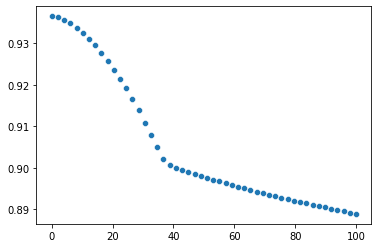

Best Model Summary
Housing Sale Price Equation = (-266822.39570138045)xCondition2_PosN + (-29022.41942554098)xHeating_OthW + (-21072.52922870754)xBldgType_TwnhsE + (-19230.609733944042)xLotShape_IR3 + (-17512.075060281193)xExterior2nd_WdShing + (-17267.223631029054)xHouseStyle_2.5Fin + (-17167.268545335162)xExterior2nd_Stucco + (-16025.47530878542)xRoofStyle_Gable + (-15449.969293771564)xKitchenAbvGr + (-10581.145145461345)xRoofStyle_Hip + (-9083.260026901842)xNeighborhood_Edwards + (-7539.444760854215)xLandSlope + (-7394.471256526944)xMSSubClass_120 + (-6872.206754698885)xCondition1_RRAe + (-6687.28833672457)xLotConfig_FR2 + (-5680.531490070377)xNeighborhood_Mitchel + (-4923.736197279994)xBldgType_2FmCon + (-4647.627223499083)xGarageCond + (-4641.528014829805)xCondition1_Feedr + (-4522.872787252218)xHouseStyle_2.5Unf + (-4336.538836230817)xNeighborhood_CollgCr + (-4308.28936827454)xLowQualFinSF + (-4062.386098374347)xExterior2nd_WdSdng + (-3942.6657155264684)xFence + (-3756.2081515676

findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeFiveSym' (STIXSizFiveSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal norma

findfont: score(<Font 'AppleGothic' (AppleGothic.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Menlo' (Menlo.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W4.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Sundanese' (NotoSansSundanese-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Khudawadi' (NotoSansKhudawadi-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.Arabic UI Text' (ArabicUIText.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Georgia' (Georgia Bold Italic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Noto Sans C

findfont: score(<Font 'Noto Sans Kannada' (NotoSansKannada.ttc) normal normal 900 normal>) = 10.525
findfont: score(<Font 'Arial' (Arial.ttf) normal normal 400 normal>) = 6.413636363636363
findfont: score(<Font 'Noto Sans Palmyrene' (NotoSansPalmyrene-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Myanmar Sangam MN' (Myanmar Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font '.New York' (NewYorkItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Comic Sans MS' (Comic Sans MS.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXIntegralsUpD' (STIXIntUpDReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial Unicode MS' (Arial Unicode.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Old Hungarian' (NotoSansOldHungarian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Fo

findfont: score(<Font 'Waseem' (Waseem.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tamil MN' (Tamil MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Sora Sompeng' (NotoSansSoraSompeng-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Sathu' (Sathu.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Tahoma' (Tahoma Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Noto Sans Vai' (NotoSansVai-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Lisu' (NotoSansLisu-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font '.Aqua Kana' (AquaKana.ttc) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Apple Braille' (Apple Braille Pinpoint 6 Dot.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Old North Arabian' (NotoSansOldNorth

findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliq.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Syloti Nagri' (NotoSansSylotiNagri-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kokonor' (Kokonor.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Geeza Pro' (GeezaPro.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Old Persian' (NotoSansOldPersian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Diwan Kufi' (Diwan Kufi.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font '.SF NS Rounded' (SFNSRounded.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Kaithi' (NotoSansKaithi-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Copperplate' (Copperplate.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Phags

findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Takri' (NotoSansTakri-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Muna' (Muna.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W1.ttc) normal normal 200 normal>) = 10.24
findfont: score(<Font 'Snell Roundhand' (SnellRoundhand.ttc) normal normal 500 normal>) = 10.145
findfont: score(<Font 'Noto Sans Mongolian' (NotoSansMongolian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Javanese' (NotoSansJavanese-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kohinoor Devanagari' (Kohinoor.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'PT Serif' (PTSerif.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Siddham' (NotoSansSiddham-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'AppleMyung

findfont: score(<Font 'Raanana' (Raanana.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bradley Hand' (Bradley Hand Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Hiragino Sans' (ヒラギノ角ゴシック W7.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXGeneral' (STIXGeneral.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Zapf Dingbats' (ZapfDingbats.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'InaiMathi' (InaiMathi-MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Thaana' (NotoSansThaana-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Apple Chancery' (Apple Chancery.ttf) normal normal 0 normal>) = 10.43
findfont: score(<Font 'Al Tarikh' (Al Tarikh.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Symbol' (Symbol.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Bold Italic.ttf) italic normal 700 normal>) =

findfont: score(<Font 'STIXIntegralsUp' (STIXIntUpReg.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Glagolitic' (NotoSansGlagolitic-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Shree Devanagari 714' (Shree714.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Serif Balinese' (NotoSerifBalinese-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Kayah Li' (NotoSansKayahLi-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Superclarendon' (SuperClarendon.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Athelas' (Athelas.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kohinoor Gujarati' (KohinoorGujarati.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Arial Black' (Arial Black.ttf) normal normal 900 normal>) = 10.525

findfont: score(<Font 'Sinhala MN' (Sinhala MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Caucasian Albanian' (NotoSansCaucasianAlbanian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Samaritan' (NotoSansSamaritan-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Seravek' (Seravek.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Optima' (Optima.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Inscriptional Parthian' (NotoSansInscriptionalParthian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Hanifi Rohingya' (NotoSansHanifiRohingya-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Mishafi Gold' (Mishafi Gold.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet MS Italic.tt

findfont: score(<Font 'Noto Sans Modi' (NotoSansModi-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Nadeem' (Nadeem.ttc) normal normal 400 normal>) = 10.05
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=16.0 to DejaVu Sans ('/Users/asgupta/.pyenv/versions/3.9.1/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal

findfont: score(<Font 'Noto Sans Myanmar' (NotoSansMyanmar.ttc) normal normal 900 normal>) = 10.525
findfont: score(<Font 'Noto Sans Bassa Vah' (NotoSansBassaVah-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Hiragino Maru Gothic Pro' (ヒラギノ丸ゴ ProN W4.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Carian' (NotoSansCarian-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Big Caslon' (BigCaslon.ttf) normal normal 500 normal>) = 10.145
findfont: score(<Font 'Noto Sans Tai Le' (NotoSansTaiLe-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Osmanya' (NotoSansOsmanya-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Newa' (NotoSansNewa-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (Courier New Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Tamil Sangam MN' (Tamil Sangam MN.ttc) normal normal 400 nor

findfont: score(<Font 'Noto Sans Runic' (NotoSansRunic-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Marker Felt' (MarkerFelt.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Telugu Sangam MN' (Telugu Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Devanagari Sangam MN' (Devanagari Sangam MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Iowan Old Style' (Iowan Old Style.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Arial Narrow' (Arial Narrow Bold Italic.ttf) italic normal 700 condensed>) = 11.535
findfont: score(<Font '.SF Compact' (SFCompact.ttf) normal normal 1000 normal>) = 10.62
findfont: score(<Font 'PT Sans' (PTSans.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lao Sangam MN' (Lao Sangam MN.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Georgia' (Georgia.ttf

findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times New Roman' (Times New Roman.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Linear A' (NotoSansLinearA-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft Sans Serif' (Microsoft Sans Serif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni 72 Oldstyle' (Bodoni 72 OS.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Kannada MN' (Kannada MN.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Herculanum' (Herculanum.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Phosphate' (Phosphate.ttc) 

findfont: score(<Font 'Avenir Next Condensed' (Avenir Next Condensed.ttc) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Noto Sans Mahajani' (NotoSansMahajani-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Academy Engraved LET' (Academy Engraved LET Fonts.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXIntegralsUpSm' (STIXIntUpSmBol.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Batak' (NotoSansBatak-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'System Font' (SFNS.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans Rejang' (NotoSansRejang-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'ITF Devanagari' (ITFDevanagari.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Papyrus' (Papyrus.ttc) normal normal 400 condensed>

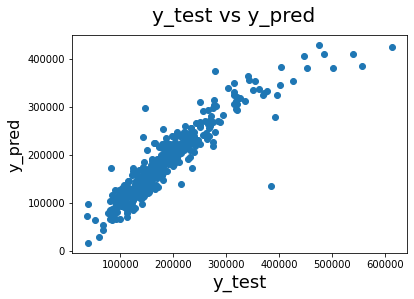

Regularization Coefficient: 0.0
R2 Score: -8.655691648222492
Residual Sum of Squares: 61610060107934.0
Root Mean Squared Error: 245647.8374562823
Regularization Coefficient: 2.0408163265306123
R2 Score: 0.8928659804486283
Residual Sum of Squares: 683589909934.5902
Root Mean Squared Error: 25875.273611324596
Regularization Coefficient: 4.081632653061225
R2 Score: 0.884819431143489
Residual Sum of Squares: 734932517425.8253
Root Mean Squared Error: 26829.39383550497
Regularization Coefficient: 6.122448979591837
R2 Score: 0.8795998178098913
Residual Sum of Squares: 768237297957.2471
Root Mean Squared Error: 27430.569426052032
Regularization Coefficient: 8.16326530612245
R2 Score: 0.8756362410476236
Residual Sum of Squares: 793527687445.8837
Root Mean Squared Error: 27878.42093827481
Regularization Coefficient: 10.204081632653061
R2 Score: 0.872398900681279
Residual Sum of Squares: 814184181234.9172
Root Mean Squared Error: 28238.944448752733
Regularization Coefficient: 12.244897959183675


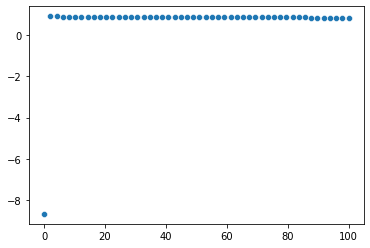

Best Model Summary
Housing Sale Price Equation = (-10934.655257639566)xBldgType_TwnhsE + (-9022.195269898379)xNeighborhood_CollgCr + (-8547.044497493458)xNeighborhood_Gilbert + (-7792.567613276702)xNeighborhood_Edwards + (-7700.214022358199)xMSSubClass_120 + (-7058.703675474991)xExterior2nd_WdShing + (-6884.027720094861)xLandSlope + (-6276.495622855308)xKitchenAbvGr + (-5992.250724974286)xLotConfig_FR2 + (-5831.457237820147)xCondition2_PosN + (-5055.86791369161)xNeighborhood_Timber + (-4970.803054710505)xHouseStyle_SLvl + (-4930.156499304627)xNeighborhood_NWAmes + (-4818.2540082021715)xHouseStyle_SFoyer + (-4728.28171262479)xRoofStyle_Gable + (-4228.056953471586)xExterior2nd_Stucco + (-4053.4147602400512)xExterior1st_Stucco + (-3924.3278799132727)xMSSubClass_80 + (-3815.6125429253675)xNeighborhood_Names + (-3797.2297300834293)xNeighborhood_Mitchel + (-3792.6881350094245)xMSSubClass_160 + (-3774.8042548522226)xFence + (-3640.772942372892)xNeighborhood_SawyerW + (-3407.7018016938123)xLot

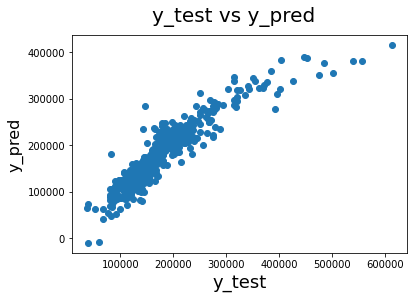

In [40]:
main()